## 6.1. Когда и целого леса мало
В прошлом модуле мы узнали об ансамблировании моделей. Одним из представителей такого подхода является случайный лес.

Случайный лес  — это композиция глубоких деревьев, которые строятся независимо друг от друга.

Такой подход имеет следующую проблему: обучение глубоких деревьев требует очень много вычислительных ресурсов, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведёт к тому, что сдвиг (bias) будет слишком большим.

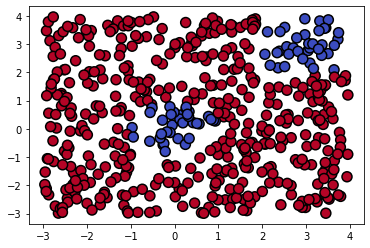

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators=5, max_depth=3, n_jobs=-1, 
                                    random_state=RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators=5, max_depth=6, n_jobs=-1, 
                                 random_state=RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

Text(0.5, 1.0, 'Deep Random Forest')

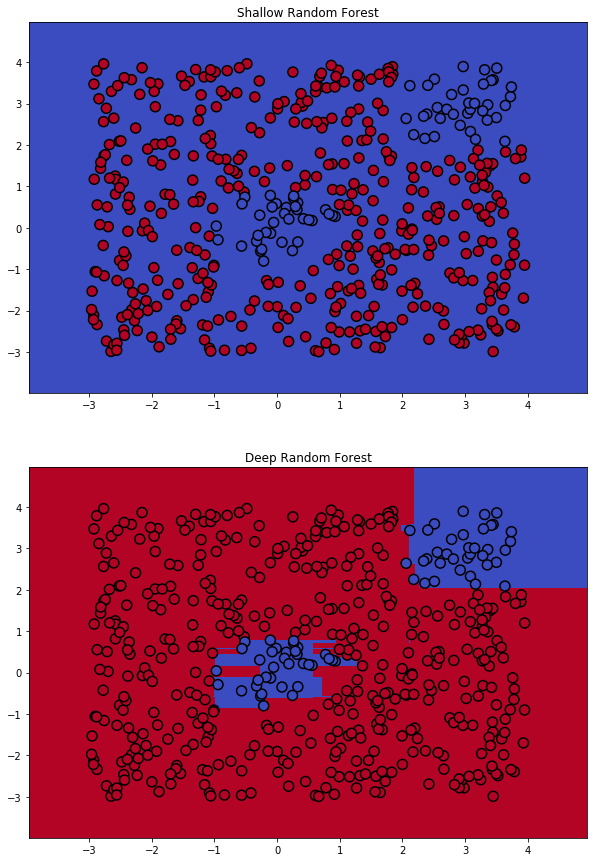

In [2]:
fig, ax = plt.subplots(2, 1, figsize=(10,15))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

### Задание 6.1.1
Как можно заметить, на первой картинке модель, сохраненная в переменную predicted_shallow, недообучается — выделяет не все синие точки на графике. После увеличения глубины в модели predicted_deep на графике практически все наблюдения отмечаются правильным классом. Как будет выглядеть график, если мы еще больше увеличим глубину (например, до 100)?




In [3]:
deepest_rf = RandomForestClassifier(n_estimators=5, max_depth=100, n_jobs=-1, 
                                 random_state=RANDOM_SEED)
deepest_rf.fit(train_data, train_labels)
predicted_deepest = deepest_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

Text(0.5, 1.0, 'Deepest Random Forest')

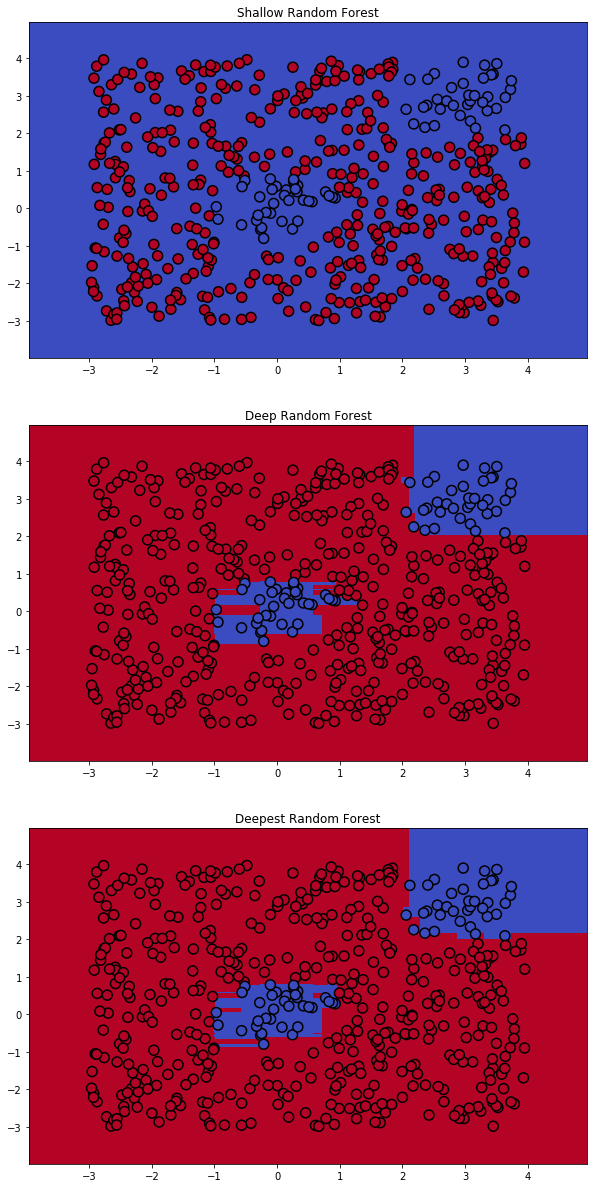

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(10,21))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

ax[2].pcolormesh(xx, yy, predicted_deepest, cmap='coolwarm')
ax[2].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[2].set_title('Deepest Random Forest')

## 6.2. AdaBoost
### АЛГОРИТМ
Первый ансамбль в этом разделе, который мы рассмотрим, называется AdaBoost (Adaptive Boosting). Бустинг позволяет из большого количества относительно слабых и простых моделей получить одну сильную. В нашем случае будут рассматриваться деревья решений ограниченной глубины.

Алгоритм построение AdaBoost:

1. Инициализируем веса объектов  $w_j = \frac{1}{N}, \, j=1,2,\dots,N$

2. Для всех $i$ от 1 до T:  
1) Строим классификатор  $b_i(x)$, используя веса $w_j$ .  
2) Вычисляем ошибку $err_i = \frac{\sum\limits_{j=1}^{N}w_j[y_j \neq b_i(x_j)]}{\sum\limits_{j=1}^{N}w_j}$  
3) Вычисляем вес нового алгоритма  $c_i = \frac{1}{2} \log{\frac{1-err_i}{err_i}}$  
4) Получаем новые веса объектов $w_j \leftarrow w_j \cdot exp\left( c_i [y_j \neq b_i(x_j)]\right), \, j = 1, \dots, N.$  
5) Нормируем веса объектов $w_j \leftarrow \frac{w_j}{\sum\limits_{j=1}^{N}w_j}.$

3. Группируем полученные модели: [Math Processing Error]   

## 6.4. Бустинг. Практика
### Задание 6.4.1
Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [5]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')

Из столбца `yesno` сделайте столбец `spam`, где 1 соответствует значению y (является спамом), а 0 – n (не является спамом). Удалите первый столбец (с индексом) и столбец `yesno`.

У Вас остается шесть столбцов-признаков и один столбец spam, который является нашей целевой переменной. Разделим их на x и у.

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

In [7]:
y = (df.yesno == 'y').astype(np.dtype('int8'))
X = df.drop(columns=['yesno','Unnamed: 0'])

poly = PolynomialFeatures(interaction_only=True,include_bias=False)
X_poly = poly.fit_transform(X)

In [8]:
X_poly.shape, poly.n_output_features_

((4601, 21), 21)

In [9]:
# poly.get_feature_names(X.columns)

### Задание 6.4.2
Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20. Обучите модель `GradientBoostingClassifier` (из библиотеки `sklearn`) с параметрами по умолчанию (на момент создания урока это `learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None`).

Во всех методах, где присутствует случайность, укажите `random_state=42`.

Это будет наш **baseline**. Укажите точность на тестовой выборке (параметр `score`), округлив до третьего знака после точки-разделителя.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=0.2,random_state=42)

In [11]:
GBC = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2,
                                 min_samples_leaf=1, subsample=1,max_features=None,random_state=42)
GBC.fit(X_train,y_train)
score = GBC.score(X_test,y_test)
round(score,3)

0.865

### Задание 6.4.3
Воспользуйтесь методом `feature_importances_`. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. В ответе укажите третий по важности признак (без кавычек и пробелов).

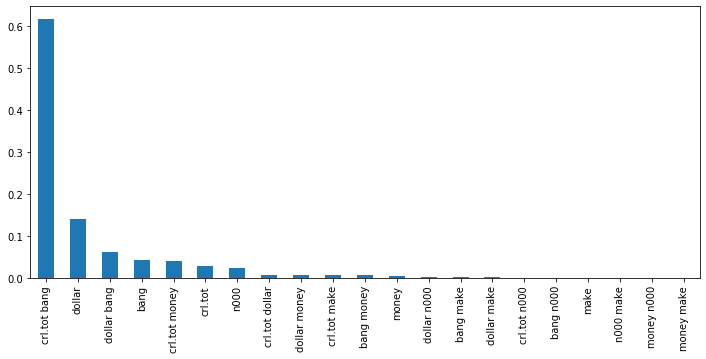

In [12]:
feature_importances = pd.Series(GBC.feature_importances_, 
                                index=poly.get_feature_names(X.columns)).sort_values(ascending=False)

feature_importances.plot.bar(figsize=(12,5))

In [13]:
feature_importances.index[2]

'dollar bang'

### Задание 6.4.4
Теперь перейдем к подбору параметров в модели. Для этого в библиотеке scikit-learn есть метод GridSearchCV. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода fit модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве estimator градиетный бустинг с параметрами по дефолту и random_state=42. В параметре scoring укажите 'accuracy', n_jobs=-1, cv=5.

Сетку параметров задайте такой:
```python
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}
```

In [14]:
model = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}
grid = GridSearchCV(model,param_grid,scoring='accuracy', n_jobs=-1, cv=5)

In [15]:
%%time
grid.fit(X_train,y_train)

Wall time: 1min 34s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [16]:
round(grid.best_score_,3)

0.884

### Задание 6.4.5
Подбор параметров — незаменимый инструмент при настройке моделей. Однако, если данных очень много, а модель сложная, то иногда имеет смысл ограничить количество параметров, которые вы хотите перебрать. Если модель с одним набором параметров обучается 30 минут, а вы хотите перебрать 10 таких наборов, то стоит приготовиться к пятичасовому ожиданию. Также стоит учитывать, что размер некоторых параметров влияет на время, потраченное на обучение моделей. Например, менее глубокие деревья учатся быстрее, чем глубокие.

При использовании `GridSearchCV` перебираются все возможные способы комбинации параметров. Сколько разных моделей (моделей градиентного бустинга с разными наборами параметров) обучилось в прошлом задании?

In [17]:
len(grid.cv_results_['params']), 

(48,)

### Задание 6.4.6
Теперь воспользуемся `GridSearchCV` для подбора максимальной глубины (`max_depth`). В качестве estimator используйте градиентный бустинг с раннеее подобранными параметрами и `random_state=42`. Переберите все значения `max_depth` от 5 до 15 включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [18]:
grid.best_params_

{'learning_rate': 0.01, 'n_estimators': 1250}

In [19]:
model = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1250,random_state=42)
param_grid = dict(max_depth = range(5,16))




In [20]:
grid_2 = GridSearchCV(model,param_grid,scoring='accuracy', n_jobs=-1, cv=5)

In [21]:
grid_2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.01,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=1250,
                                                  n_iter_no_change=None,
                                                  presor

In [22]:
grid_2.best_params_

{'max_depth': 5}

### Задание 6.4.7
Может показаться, что, научившись запускать готовые фукнции из библиотек и настривать параметры, мы абсолютно готовы к работе. Однако на поле боя нас могут подстерегать еще опасности — *legacy code*, то есть код, написанный кем-то до вас. Может быть, его можно было бы и улучшить, но на нём уже столько всего надстроено, что переписывать всё практически невозможно.

А ещё часто будет возникать необходимость просто понять код коллеги или сделать *code review* (грубо говоря, это анализ кода на предмет ошибок и расхождения в стиле). Во всех этих ситуациях необходим навык быcтрого чтения кода.

Поэтому в качестве примера в этом задании мы предлагаем изучить код для реализации **AdaBoost** с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете (до разделения выборки на обучающую и тестовую). Параметр `learning_rate` возьмите равным 0.001, М = 10. В ответ запишите точность, округленную до трёх знаков после точки-разделителя.

За основу нужно взять следующий код:

In [23]:
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y).values

        # Оцениваем ошибку
        estimator_error = (sample_weight*incorrect).sum() / sample_weight.sum()
#         print(estimator_error)
        
        # Вычисляем вес нового алгоритма
        estimator_weight = 1/2*np.log((1-estimator_error)/estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(-estimator_weight * incorrect ) # * ((sample_weight > 0) | (estimator_weight < 0))
        print(sample_weight.sum())
        
        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X_poly, y, M=10, learning_rate=0.001)

0.905049843603982
0.8488378643063901
0.8274791063203716
0.8232101554243807
0.8228716761077436
0.8228646154273065
0.8228645946566369
0.8228645946533363
0.8228645946533363
0.8228645946533363
Accuracy =  0.8228645946533363


## 6.6. Стекинг. Практика
Разберём стекинг на практике, проанализировав датасет, описывающий параметры, которые были сняты со спутника при фотографировании Земли. У нас есть 54 переменные. Для упрощения будем рассматривать два типа поверхностей —так мы сводим нашу задачу к **задаче бинарной классификации**. Сделаем базовую предобработку, воспользуемся `StandardScaler`.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

**Стекинг** позволяет объединять ответы нескольких алгоритмов первого уровня в один большой ответ при помощи **нового алгоритма** обучения. Для избежания переобучения будем разбивать обучающую выбоку на **фолды** — разбиение обучающей выборки на несколько частей. На каждом фолде мы обучаем алгоритм **заново**.

**Функция** `compute_meta_feature` принимает на вход один алгоритм и возвращает новые признаки на объектах, которые не использовались во время обучения. **Функция** `generate_meta_feature` делает подобное, но принимает на вход несколько классификаторов в списке и повторяет процедуру, а затем генерирует и возвращает матрицу с изначальным количеством объектов, признаков будет столько, сколько мы передали классификаторов. 

In [25]:
def compute_metafeature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_metafeature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [26]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', sep=',', header=None)[:10000]

In [27]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2


In [28]:
features = list(range(0, 54))
target = 54

df = df[(df[target] == 1) | (df[target] == 2)]

In [29]:
cover_train, cover_test = train_test_split(df, test_size=0.5)

cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]

In [30]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)

In [31]:
np.random.seed(42)

clf = GradientBoostingClassifier(n_estimators=300)
clf.fit(cover_X_train, cover_y_train)

accuracy_score(clf.predict(cover_X_test), cover_y_test)

0.7716701902748414

In [32]:
cv = KFold(n_splits=10, shuffle=True)

stacked_features_train, stacked_features_test = generate_metafeatures([
    LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
    LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=300)
], cover_X_train, cover_X_test, cover_y_train.values, cv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.68s/it]


In [33]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])

In [34]:
np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, cover_y_train)
accuracy_score(clf.predict(stacked_features_test), cover_y_test)

0.8033826638477801

## Практика
Все задания выполняются на основе датасета `digits dataset`

In [35]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

In [36]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Задание 6.6.1
В скринкасте мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

Логика решения:  
1) Создадим `X_meta_test`, заполним его нулями (по аналогии с `X_meta_train`);  
2) Далее на каждом шаге, где мы обучаем `folded_clf.fit (X_fold_train, y_fold_train)` и его предсказания на `X_fold_predict` запихиваем в `X_meta_train[predict_fold_index]` добавим еще одну строку, где в `X_meta_test` будем добавлять предсказания вероятностей `folded_clf` на `X_test`. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);  
3) После цикла останется только усреднить все эти массивы, это и будет наш `X_meta_test`.  
**За основу нужно взять следующий код:**

In [37]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     Они являются вероятностями классов при решении задачи многоклассовой классификации.    :arg clf: классификатор    :args X_train, y_train: обучающая выборка    :arg X_test: признаки тестовой выборки    :arg cv: класс, генерирующий фолды (KFold)    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict_proba(X_test)

    return X_meta_train, X_meta_test

### Решение

In [38]:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """    
    Эта функция подсчитывает признаки для мета-классификатора.
    Они являются вероятностями классов при решении задачи многоклассовой классификации.
    
    :arg  clf: классификатор
    :args X_train, y_train: обучающая выборка
    :arg  X_test: признаки тестовой выборки
    :arg  cv: класс, генерирующий фолды (KFold)
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
    n_splits = cv.get_n_splits()
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        
        X_meta_test += folded_clf.predict_proba(X_test)/n_splits

    return X_meta_train, X_meta_test

### Для следующих заданий используйте этот код:

In [39]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

### ПОДСКАЗКА
- Во всех случаях, когда модель принимает `random_state` — обязательно указывайте его равным 42
- На разных версиях sklearn ответы могут отличаться
- В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания.

### Задание 6.6.2
Используйте **функцию** `generate_meta_features` для стекинга следующих алгоритмов:
- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000
- логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000
- случайный лес из 300 деревьев
- градиентный бустинг из 200 деревьев  

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `lbfgs`.
Посчитайте качество при помощи передачи новых признаков в **функцию** `compute_metric`.

In [40]:
clf_1 = LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=2000, multi_class='ovr', random_state=42)
clf_2 = LogisticRegression(penalty='l2', C=0.001, solver='saga', max_iter=2000, multi_class='multinomial', random_state=42)
clf_3 = RandomForestClassifier(n_estimators=300, random_state=42)
clf_4 = GradientBoostingClassifier(n_estimators=200, random_state=42)
classifiers = [clf_1, clf_2, clf_3, clf_4]

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42)

In [41]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:16<00:00, 19.07s/it]


In [42]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.982686

### Задание 6.6.3
Используйте **функцию** `generate_meta_feature`s для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев
- случайный лес из 200 экстремальных деревьев  

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `lbfgs`.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

In [44]:
clf_5 = RandomForestClassifier(n_estimators=300, random_state=42) # max_features 
clf_6 = ExtraTreesClassifier(n_estimators=200, random_state=42)
classifiers = [clf_5, clf_6]

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42,max_iter=500,)

In [45]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.84s/it]


In [46]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.982421

### Задание 6.6.4
Используйте функцию `generate_meta_features` для стекинга следующих алгоритмов:
- метод ближайшего соседа (k-NN) со стандартными параметрами
- случайный лес из 300 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `lbfgs`.  
Посчитайте качество при помощи передачи новых признаков в функцию `compute_metric`.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
clf_7 = KNeighborsClassifier()
clf_8 = ExtraTreesClassifier(n_estimators=200, random_state=42)
classifiers = [clf_7, clf_8]

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42,max_iter=500)

In [49]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


In [50]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.98955

### Задание 6.6.5
Используйте **функцию** `generate_meta_features` для стекинга следующих алгоритмов:
- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000
- метод ближайшего соседа со стандартными параметрами
- случайный лес из 300 экстремальных деревьев
- AdaBoost со стандартными параметрами

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `lbfgs`.  
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [51]:
clf_9 =  LogisticRegression(penalty='l1',C=0.001,solver='saga',multi_class='ovr',max_iter=2000,random_state=42)
clf_10 =  KNeighborsClassifier()
clf_11 =  ExtraTreesClassifier(n_estimators=300,random_state=42)
clf_12 =  AdaBoostClassifier(random_state=42)

classifiers = [clf_9, clf_10, clf_11, clf_12]

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42)

In [52]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.96s/it]


In [53]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.987404

### Задание 6.6.6
Используйте **функцию** `generate_meta_features` для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев
- случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте **класс** `StratifiedKFold`, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов).
Для корректной работы необходимо подправить код в **функции** `compute_meta_feature`.  

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `lbfgs`.  

Посчитайте качество при помощи передачи новых признаков в функцию compute_metric. Количество фолдов = 10

In [54]:
cv_strat = StratifiedKFold(n_splits=10,random_state=42)

def compute_meta_feature_strat(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train,y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features_strat(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature_strat(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test


In [55]:
clf_13 = RandomForestClassifier(n_estimators=300,random_state=42)
clf_14 = ExtraTreesClassifier(n_estimators=300,random_state=42)

classifiers = [clf_13, clf_14]

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42,)

In [56]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.92s/it]


In [57]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.983615

### Задание 6.6.7
В предыдущей задаче измените 10 фолдов на 20. Укажите полученное качество.

In [58]:
cv_strat_20 = StratifiedKFold(n_splits=20,random_state=42)

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42, max_iter=2000 )

In [59]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat_20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.16s/it]


In [60]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.978674

### Задание 6.6.8
В предыдущей задаче укажите количество фолдов равным 5 и поменяйте мета-алгоритм на случайный лес со стандартными параметрами. Укажите полученное качество.

In [61]:
cv_strat_5 = StratifiedKFold(n_splits=5,random_state=42)

clf = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs', random_state=42, max_iter=2000 )

In [62]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat_5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


In [63]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.979731

### Задание 6.6.9
В предыдущей задаче поменяйте мета-алгоритм на метод ближайших соседей (k-NN) со стандартными параметрами. Укажите полученное качество.

In [64]:
clf = KNeighborsClassifier()

In [65]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat_5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.05s/it]


In [66]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.980715

### Задание 6.6.10
В предыдущей задаче поменяйте мета-алгоритм на градиентный бустинг со стандартными параметрами. Укажите полученное качество.

In [67]:
clf = GradientBoostingClassifier(random_state=42)

In [68]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat_5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


In [69]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.985118

### Задание 6.6.11
Используйте **функцию** `generate_meta_features` для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте **класс** StratifiedKFold и поправленный Вами ранее код в **функции** `compute_meta_feature`.  
Выполните разбиение на 3 фолда.  
Как мета-алгортм используйте случайный лес из 100 экстремальных деревьев. Посчитайте качество при помощи передачи новых признаков в **функцию** `compute_metric`.

In [70]:
cv_strat_3 = StratifiedKFold(n_splits=3,random_state=42)

clf_15 = RandomForestClassifier(n_estimators=300,criterion='gini',max_depth=24,random_state=42)
clf_16 = ExtraTreesClassifier(n_estimators=300,random_state=42)


clf = ExtraTreesClassifier(n_estimators=100,random_state=42)

In [71]:
stacked_features_train, stacked_features_test = generate_meta_features_strat(classifiers,
                                                                             X_train, X_test, y_train, cv_strat_3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


In [72]:
compute_metric(clf, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.984151

### Задание 6.6.12
Обучите на тренировочной выборке следующие алгоритмы:
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев
- логистическую регрессию со стандартными параметрами

Усредните их ответы на тестовой выборке и посчитайте качество аналогично функции compute_metric (F1-score с макро-усреднением, округленный до 6 знака).

In [73]:
rfc = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=24,random_state=42)
etc = ExtraTreesClassifier(n_estimators=300,random_state=42)
lr = LogisticRegression(random_state=42)

In [74]:
rfc.fit(X_train,y_train)
etc.fit(X_train,y_train)
lr.fit(X_train,y_train)

C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
pred_rfc = rfc.predict_proba(X_test)
pred_etc = etc.predict_proba(X_test)
pred_lr = lr.predict_proba(X_test)

pred_proba = pred_rfc + pred_etc + pred_lr

pred = list(map(lambda x: x.argmax(),pred_proba))

np.round(f1_score(y_test, pred, average='macro'), 6)

0.978411

In [76]:
pred.astype(int)

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
pred_rfc = rfc.predict(X_test)
pred_etc = etc.predict(X_test)
pred_lr = lr.predict(X_test)

pred = ((pred_rfc + pred_etc + pred_lr)/3).astype(int)

np.round(f1_score(y_test, pred, average='macro'), 6)

## Подвал

In [ ]:
Boo

In [ ]:
f1_score

In [ ]:
def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

In [25]:
'''
def compute_metafeature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test
    ''';